In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('/Users/snehanarayanan/Documents/subscription_log project/netflix_revenue_updated-3.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

/var/folders/73/0dj9qt2j6q55d7g3pl3ldw8h0000gn/T/ipykernel_98792/2680743349.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [3]:
df.head()

,Global Revenue,UCAN Streaming Revenue,EMEA Streaming Revenue,LATM Streaming Revenue,APAC Streaming Revenue,UCAN Members,EMEA Members,LATM Members,APAC Members,UCAN ARPU,EMEA ARPU,LATM ARPU,APAC ARPU,Netflix Streaming Memberships
Date,,,,,,,,,,,,,,
2017-03-31,2516241000,1586167000,482282000,331453000,116339000,54575000,19699000,15425000,4664000,9.84,8.57,7.46,8.81,NaN
2017-06-30,2670727000,1624397000,533098000,381459000,131773000,55617000,21152000,17013000,5254000,9.83,8.70,7.84,8.86,NaN
2017-09-30,2874645000,1674308000,614707000,434637000,150993000,56779000,23135000,18267000,5842000,9.93,9.25,8.21,9.07,NaN
2017-12-31,3180603000,1775987000,732726000,495067000,176823000,58422000,26004000,19717000,6501000,10.28,9.94,8.69,9.55,NaN
2018-03-31,3602105000,1976157000,886649000,540182000,199117000,60909000,29339000,19717000,6501000,11.04,10.68,8.79,9.55,NaN


## Creating Global ARPU

In [3]:
df['Total Members'] = df[['UCAN Members', 'EMEA  Members', 'LATM Members', 'APAC Members']].sum(axis=1)

In [4]:
df['Global ARPU'] = (
    df['UCAN ARPU'] * df['UCAN Members'] +
    df['EMEA ARPU'] * df['EMEA  Members'] +
    df['LATM  ARPU'] * df['LATM Members'] +
    df['APAC  ARPU'] * df['APAC Members']
) / df['Total Members']


In [5]:
df.head()

,Global Revenue,UCAN Streaming Revenue,EMEA Streaming Revenue,LATM Streaming Revenue,APAC Streaming Revenue,UCAN Members,EMEA Members,LATM Members,APAC Members,UCAN ARPU,EMEA ARPU,LATM ARPU,APAC ARPU,Netflix Streaming Memberships,Total Members,Global ARPU
Date,,,,,,,,,,,,,,,,
2017-03-31,2516241000,1586167000,482282000,331453000,116339000,54575000,19699000,15425000,4664000,9.84,8.57,7.46,8.81,NaN,94363000,9.134923
2017-06-30,2670727000,1624397000,533098000,381459000,131773000,55617000,21152000,17013000,5254000,9.83,8.70,7.84,8.86,NaN,99036000,9.195342
2017-09-30,2874645000,1674308000,614707000,434637000,150993000,56779000,23135000,18267000,5842000,9.93,9.25,8.21,9.07,NaN,104023000,9.428427
2017-12-31,3180603000,1775987000,732726000,495067000,176823000,58422000,26004000,19717000,6501000,10.28,9.94,8.69,9.55,NaN,110644000,9.873859
2018-03-31,3602105000,1976157000,886649000,540182000,199117000,60909000,29339000,19717000,6501000,11.04,10.68,8.79,9.55,NaN,116466000,10.485231


In [6]:
df = df.asfreq('Q')

/var/folders/73/0dj9qt2j6q55d7g3pl3ldw8h0000gn/T/ipykernel_98792/103469699.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.asfreq('Q')


## Exploratory Data Analysis

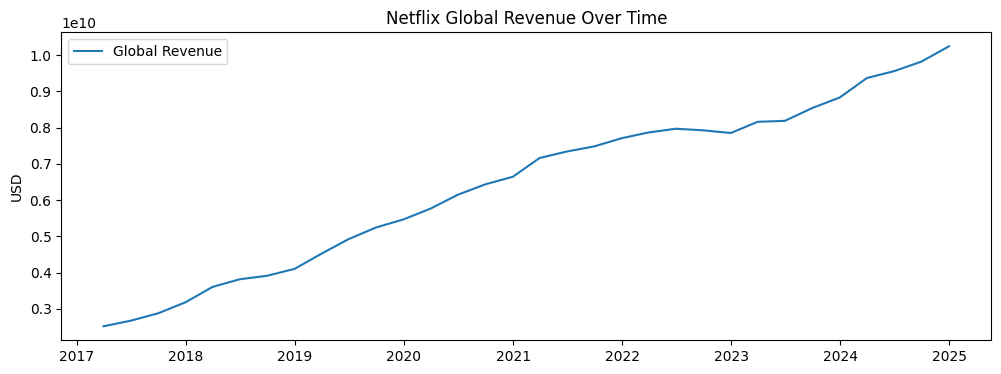

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(df['Global Revenue'], label='Global Revenue')
plt.title("Netflix Global Revenue Over Time")
plt.ylabel("USD")
plt.legend()
plt.show()

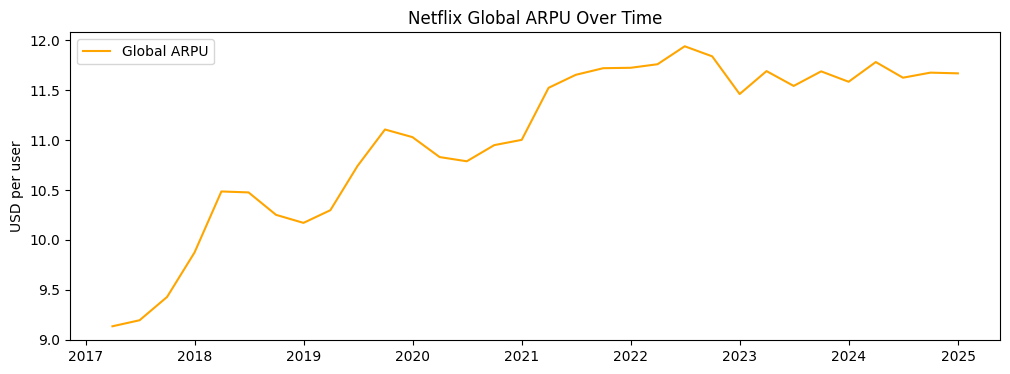

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(df['Global ARPU'], label='Global ARPU', color='orange')
plt.title("Netflix Global ARPU Over Time")
plt.ylabel("USD per user")
plt.legend()
plt.show()

## PROPHET

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
/Users/snehanarayanan/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


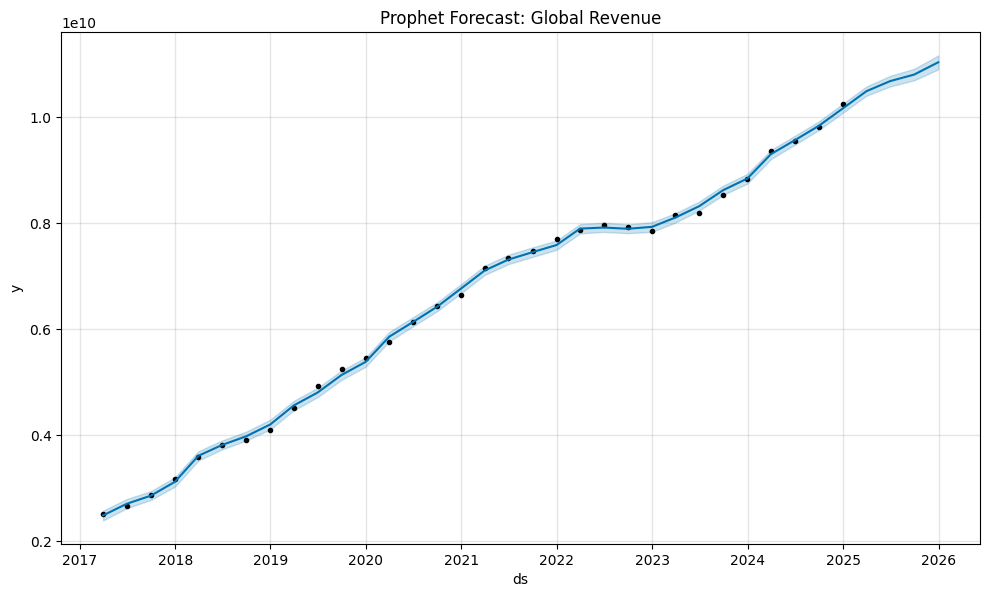

In [11]:

# 1. Prepare data for Prophet (Global Revenue)
prophet_df_rev = df[['Global Revenue']].reset_index()
prophet_df_rev.columns = ['ds', 'y']

# 2. Create and fit the Prophet model
prophet_model_rev = Prophet()
prophet_model_rev.fit(prophet_df_rev)

# 3. Forecast into 2025 (4 quarters)
future_rev = prophet_model_rev.make_future_dataframe(periods=4, freq='Q')
forecast_rev = prophet_model_rev.predict(future_rev)

# 4. Plot forecast
prophet_model_rev.plot(forecast_rev)
plt.title("Prophet Forecast: Global Revenue")
plt.show()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
/Users/snehanarayanan/Library/Python/3.9/lib/python/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


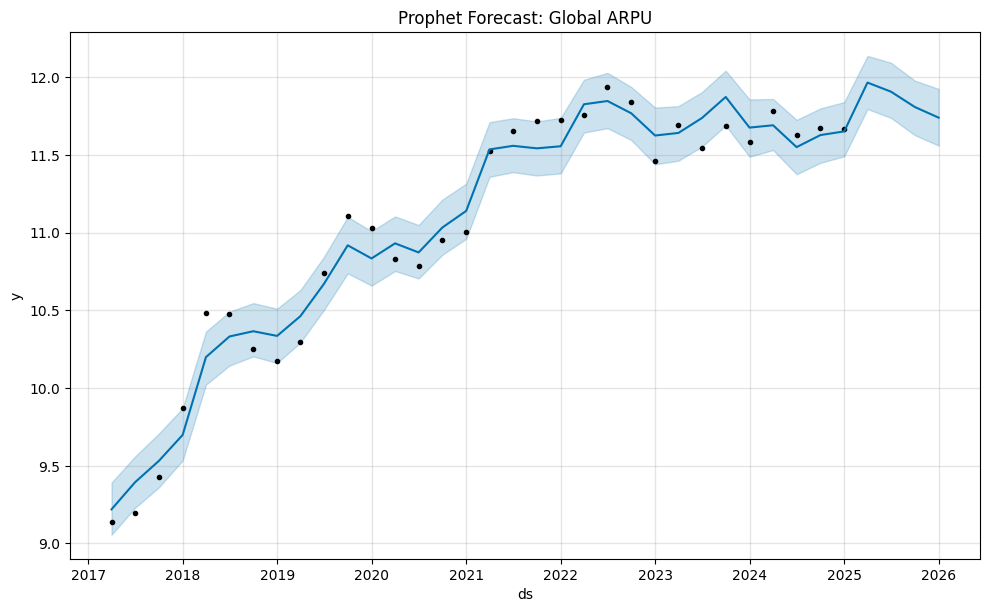

In [12]:
# --- Same process for Global ARPU ---
prophet_df_arpu = df[['Global ARPU']].reset_index()
prophet_df_arpu.columns = ['ds', 'y']
prophet_model_arpu = Prophet()
prophet_model_arpu.fit(prophet_df_arpu)
future_arpu = prophet_model_arpu.make_future_dataframe(periods=4, freq='Q')
forecast_arpu = prophet_model_arpu.predict(future_arpu)

prophet_model_arpu.plot(forecast_arpu)
plt.title("Prophet Forecast: Global ARPU")
plt.show()

## SARIMA

In [14]:
pip install numpy==1.23.5

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.4 MB 3.6 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1.6 requires cmdstanpy>=1.0.4, but you have cmdstanpy 0.9.5 which is incompatible.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=1262.751, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=1256.847, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=1259.158, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=1259.129, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=1297.691, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=1257.496, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=1256.993, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=1258.991, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=1261.654, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=1258.852, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=1260.820, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4] intercept
Total fit time: 0.677 seconds
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly a

 This problem is unconstrained.


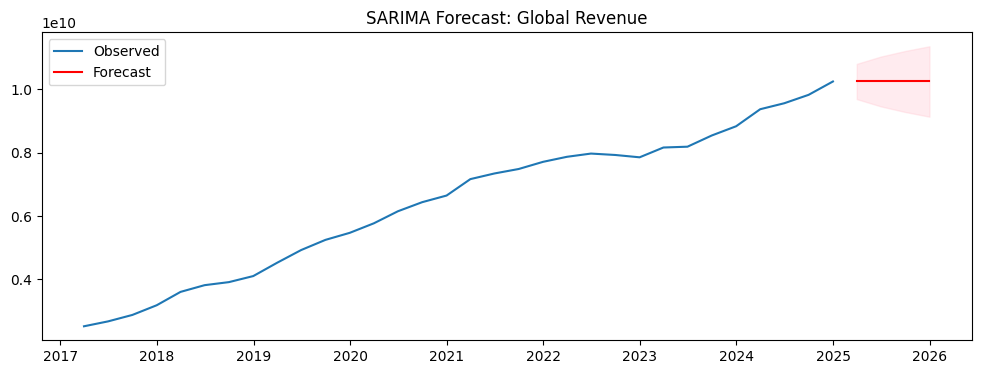

In [13]:
from pmdarima import auto_arima

# 1. SARIMA for Global Revenue
auto_model_rev = auto_arima(df['Global Revenue'], seasonal=True, m=4, trace=True)
sarima_model_rev = SARIMAX(df['Global Revenue'], order=auto_model_rev.order,
                           seasonal_order=auto_model_rev.seasonal_order)
sarima_result_rev = sarima_model_rev.fit()

# 2. Forecast
forecast_rev_sarima = sarima_result_rev.get_forecast(steps=4)
forecast_rev_mean = forecast_rev_sarima.predicted_mean
forecast_rev_ci = forecast_rev_sarima.conf_int()

# 3. Plot
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Global Revenue'], label='Observed')
plt.plot(forecast_rev_mean.index, forecast_rev_mean, label='Forecast', color='red')
plt.fill_between(forecast_rev_ci.index,
                 forecast_rev_ci.iloc[:, 0],
                 forecast_rev_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title("SARIMA Forecast: Global Revenue")
plt.legend()
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=-0.745, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-0.789, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=1.760, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=1.738, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=1.086, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=0.684, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=0.671, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=2.662, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=-0.043, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=-0.110, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=1.857, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4] intercept
Total fit time: 0.666 seconds
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.


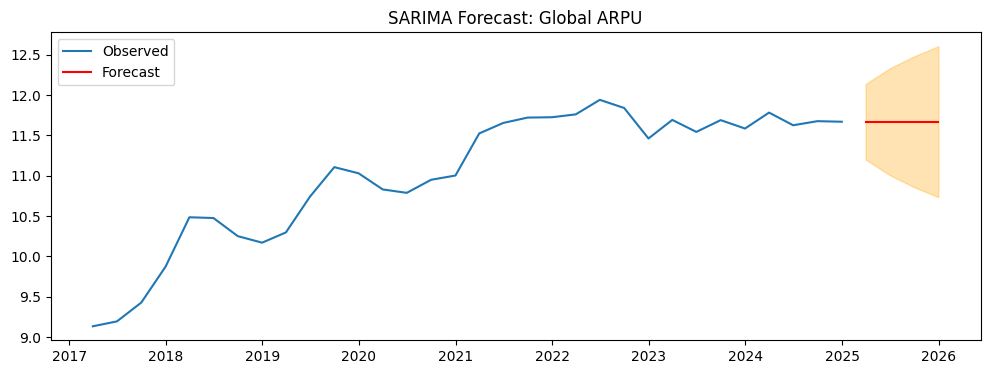

In [8]:
# --- Repeat for Global ARPU ---
auto_model_arpu = auto_arima(df['Global ARPU'], seasonal=True, m=4, trace=True)
sarima_model_arpu = SARIMAX(df['Global ARPU'], order=auto_model_arpu.order,
                            seasonal_order=auto_model_arpu.seasonal_order)
sarima_result_arpu = sarima_model_arpu.fit()
forecast_arpu_sarima = sarima_result_arpu.get_forecast(steps=4)
forecast_arpu_mean = forecast_arpu_sarima.predicted_mean
forecast_arpu_ci = forecast_arpu_sarima.conf_int()

plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Global ARPU'], label='Observed')
plt.plot(forecast_arpu_mean.index, forecast_arpu_mean, label='Forecast', color='red')
plt.fill_between(forecast_arpu_ci.index,
                 forecast_arpu_ci.iloc[:, 0],
                 forecast_arpu_ci.iloc[:, 1], color='orange', alpha=0.3)
plt.title("SARIMA Forecast: Global ARPU")
plt.legend()
plt.show()

In [14]:
# Replace with real values when known
actual_q1_2025_rev = 10,853,629  # example
actual_q1_2025_arpu = 17.56      # example

# Prophet predictions for Q1 2025
q1_2025_forecast_rev = forecast_rev.loc[forecast_rev['ds'] == '2025-03-31', 'yhat'].values[0]
q1_2025_forecast_arpu = forecast_arpu.loc[forecast_arpu['ds'] == '2025-03-31', 'yhat'].values[0]

# Evaluation Metrics
def evaluate(actual, predicted):
    mae = np.abs(actual - predicted)
    mape = (mae / actual) * 100
    return round(mae, 2), round(mape, 2)

rev_mae, rev_mape = evaluate(actual_q1_2025_rev, q1_2025_forecast_rev)
arpu_mae, arpu_mape = evaluate(actual_q1_2025_arpu, q1_2025_forecast_arpu)

print(f"Global Revenue – MAE: {rev_mae}, MAPE: {rev_mape}%")
print(f"Global ARPU – MAE: {arpu_mae}, MAPE: {arpu_mape}%")


TypeError: type numpy.ndarray doesn't define __round__ method

In [16]:
# Replace with real values when known
actual_q1_2025_rev = 10853629  # example
actual_q1_2025_arpu = 17.35      # example

# Prophet predictions for Q1 2025
q1_2025_forecast_rev = forecast_rev.loc[forecast_rev['ds'] == '2025-03-31', 'yhat'].values[0]
q1_2025_forecast_arpu = forecast_arpu.loc[forecast_arpu['ds'] == '2025-03-31', 'yhat'].values[0]

# Evaluation Metrics
def evaluate(actual, predicted):
    mae = np.abs(actual - predicted)
    mape = (mae / actual) * 100
    return round(mae, 2), round(mape, 2)

rev_mae, rev_mape = evaluate(actual_q1_2025_rev, q1_2025_forecast_rev)
arpu_mae, arpu_mape = evaluate(actual_q1_2025_arpu, q1_2025_forecast_arpu)

print(f"Global Revenue – MAE: {rev_mae}, MAPE: {rev_mape}%")
print(f"Global ARPU – MAE: {arpu_mae}, MAPE: {arpu_mape}%")

Global Revenue – MAE: 10483165668.87, MAPE: 96586.73%
Global ARPU – MAE: 5.39, MAPE: 31.04%
